# Telco Churn

In [1]:
from env import password, host, user, url
from env import sql_database
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# ignore warnings
import warnings

In [2]:
query = '''

SELECT * 
FROM customers
JOIN contract_types USING (contract_type_id)
JOIN payment_types USING (payment_type_id)
JOIN internet_service_types USING (internet_service_type_id);

'''

data_base_name = "telco_churn"

df = sql_database(query, data_base_name)

In [3]:
df.total_charges.str.contains(' ').value_counts()

False    7032
True       11
Name: total_charges, dtype: int64

In [4]:
df.total_charges = df.total_charges.replace(" ", df.tenure*df.monthly_charges)
df.total_charges = df.total_charges.astype(float)

In [5]:
df.head()

,internet_service_type_id,payment_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type
0,1,2,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.40,No,Month-to-month,Mailed check,DSL
1,1,4,1,0013-MHZWF,Female,0,No,Yes,9,Yes,...,Yes,Yes,Yes,Yes,69.4,571.45,No,Month-to-month,Credit card (automatic),DSL
2,1,1,1,0015-UOCOJ,Female,1,No,No,7,Yes,...,No,No,No,Yes,48.2,340.35,No,Month-to-month,Electronic check,DSL
3,1,1,1,0023-HGHWL,Male,1,No,No,1,No,...,No,No,No,Yes,25.1,25.10,Yes,Month-to-month,Electronic check,DSL
4,1,3,1,0032-PGELS,Female,0,Yes,Yes,1,No,...,No,No,No,No,30.5,30.50,Yes,Month-to-month,Bank transfer (automatic),DSL


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
internet_service_type_id    7043 non-null int64
payment_type_id             7043 non-null int64
contract_type_id            7043 non-null int64
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
phone_service               7043 non-null object
multiple_lines              7043 non-null object
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
paperless_billing           7043 non-null object
monthly_charges 

In [7]:
df.tenure.sort_values()

6143     0
6569     0
6895     0
2132     0
6615     0
        ..
1811    72
1950    72
5193    72
6750    72
5139    72
Name: tenure, Length: 7043, dtype: int64

In [8]:
train, test = train_test_split(df, random_state = 123, train_size=.8)
train, validate = train_test_split(train, random_state=123, train_size=.75)

In [9]:
train['is_churn'] = (train.churn == "Yes")

In [10]:
explore_int = train.select_dtypes(exclude="object")

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Churn')

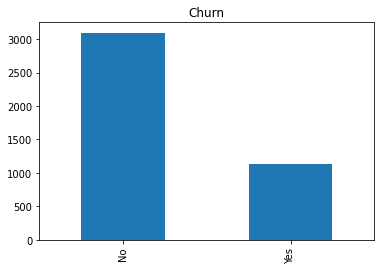

In [11]:
train.churn.value_counts().plot("bar").set_title("Churn")

About 26% of customers are currently churning

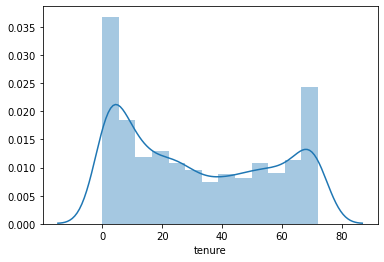

In [12]:
sns.distplot(train.tenure)

The data is not normally distributed - we will defininitvely needs to scale it. 

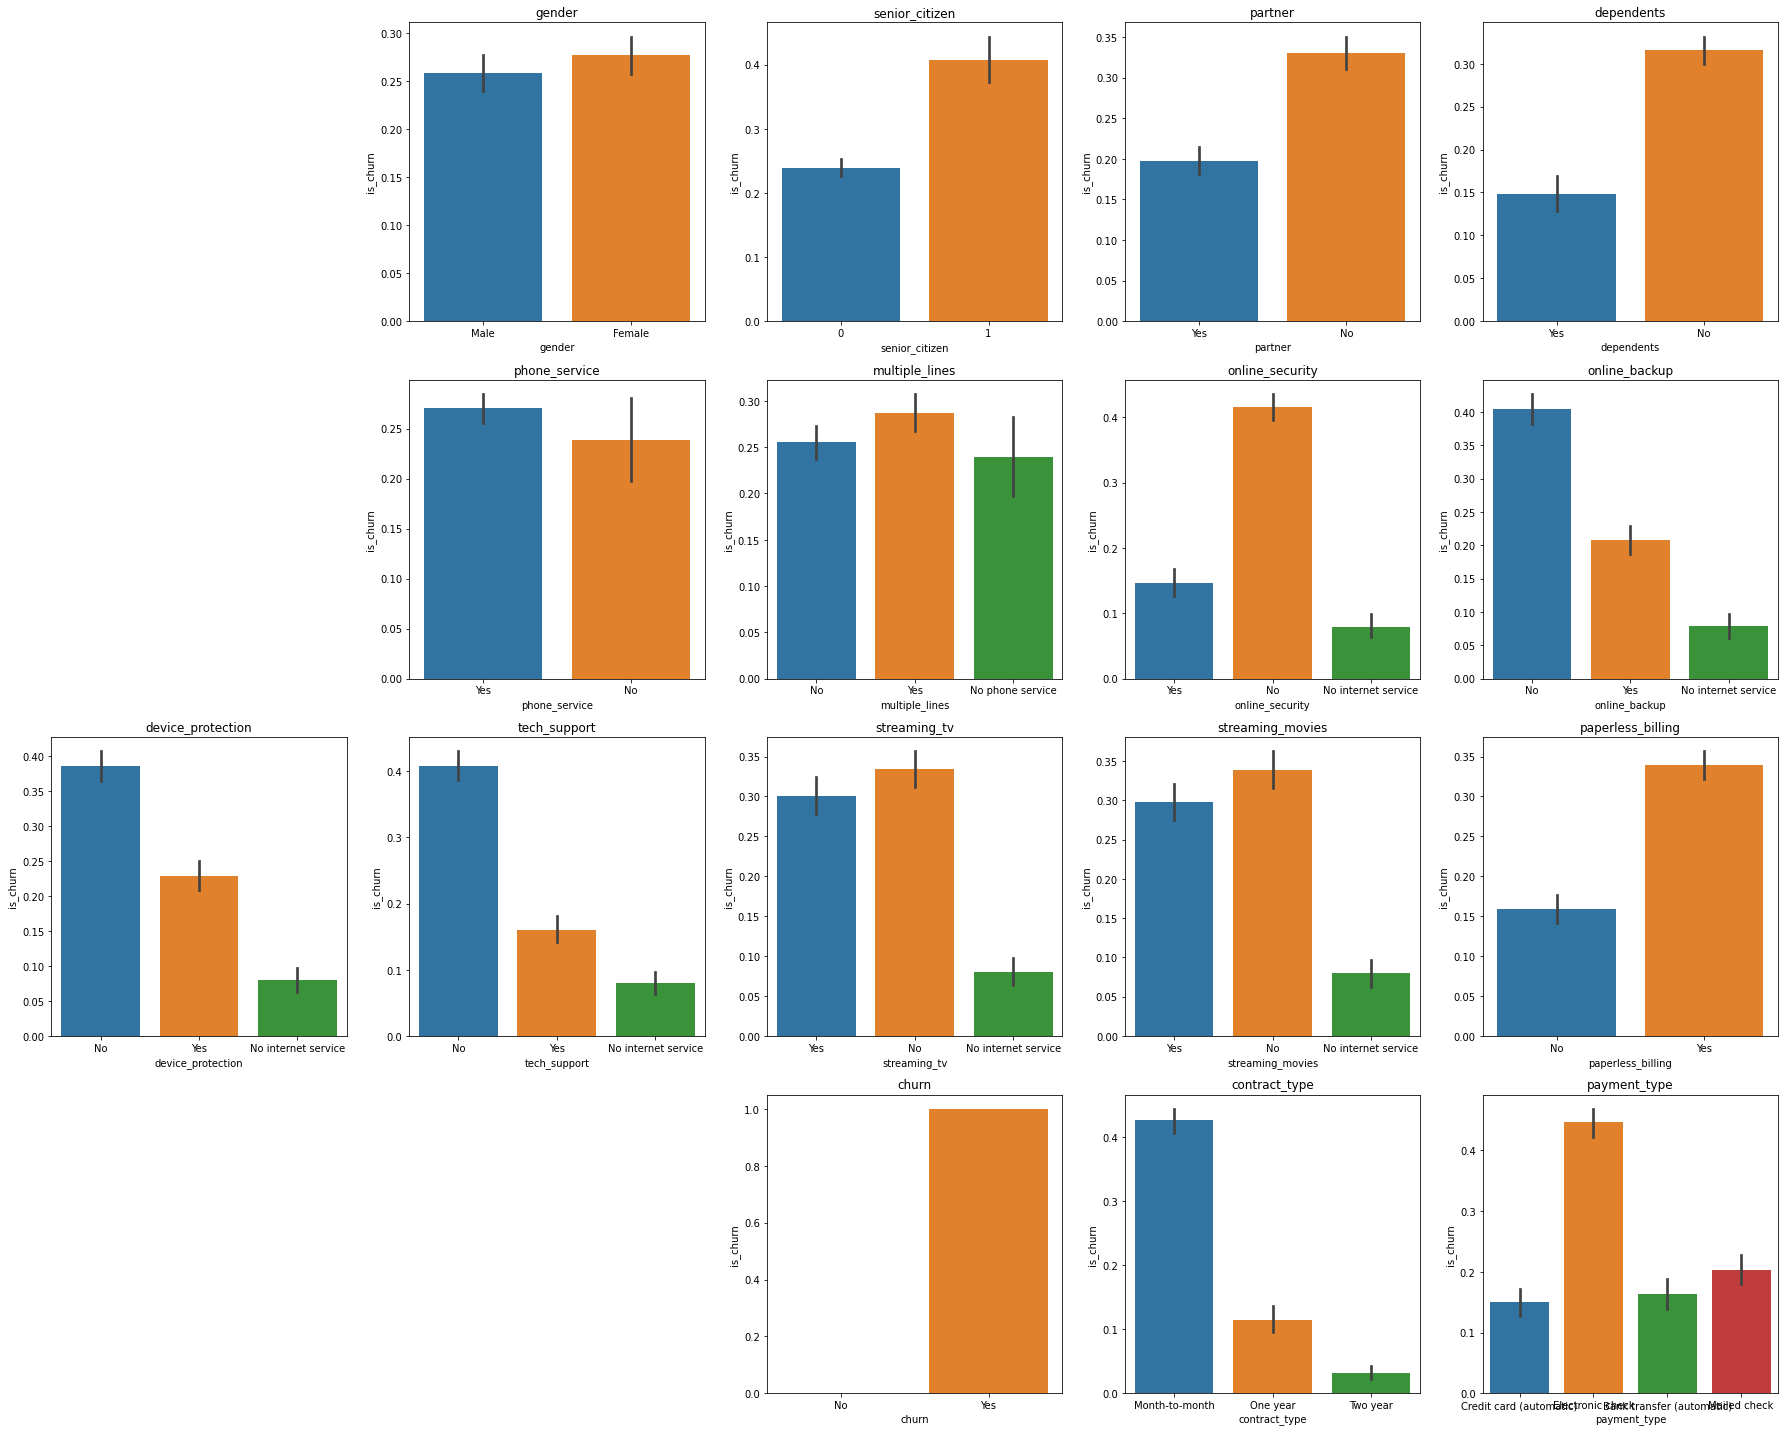

In [26]:
f = plt.figure(figsize=(25,20))

for i in range(0,21):
    if len(train.groupby(train.iloc[:,i+3])) < 5:
        f.add_subplot(4,5, i+1)
        sns.barplot(data=train, y="is_churn", x=train.iloc[:,i+3])
        plt.title(train.columns[i+3])
plt.tight_layout()
plt.show()

Are there clear groupings where a customer is more likely to churn?

There are actually quite a lot of groupings that can serve as an indicator of churn. It might be too many, however, and some new features might need to be engineered. 

From what we can see - the features that at this point don't seem to have any major differences are:

* `gender`
* `phone_service`
* `multiple_lines`
* `streaming_service`

The features that seems to be some of the best indicators are:

* `payment_type`
* `contract_type`
* `internet_service_type`
* `dependents`
* `partner`

Other features that are worth investigating are:

* `online_security`
* `tech_support`
* `senior_citizen` 
* `device_protection`

These features (with the exclusion of `senior_citizen`) seem to be additional commodities that are offered, and clients that usually take up on these features seem to be less likely to churn. While this might not be as useful for modeling, this can is something that can be used as a potential metric to improve customer rentention. 

It is important first to understand what percentage of the customer population actually has these features.

In [14]:
train[train["online_security"]== "Yes"].customer_id.value_counts().sum() / train.shape[0]

0.2835502958579882

So about 28% of the customer population has opted in for online_security, which is actually higher than I initially suspected, and means it could be a good metric for modeling afterall.

In [15]:
train[train["tech_support"]== "Yes"].customer_id.value_counts().sum() / train.shape[0]

0.2849704142011834

Is there a tenure that month-to-month customers are most likely to churn

In [16]:
train.groupby(["is_churn", "contract_type"]).tenure.mean()

is_churn  contract_type 
False     Month-to-month    20.236960
          One year          40.900259
          Two year          56.945010
True      Month-to-month    13.606820
          One year          47.200000
          Two year          60.406250
Name: tenure, dtype: float64

In [17]:
for i in range(0, 3):
    print(f'''
    The average number of months we retain a customer on a {train.contract_type.unique()[0 + i]} contract is: {train[train["contract_type"] == train.contract_type.unique()[0 + i]].tenure.mean():.2f}
    '''
    )


    The average number of months we retain a customer on a Month-to-month contract is: 17.41
    

    The average number of months we retain a customer on a One year contract is: 41.62
    

    The average number of months we retain a customer on a Two year contract is: 57.05
    


In [18]:
# How many ppl are in each contract type?

train.groupby("contract_type").contract_type.count()

contract_type
Month-to-month    2339
One year           872
Two year          1014
Name: contract_type, dtype: int64

The majority of customers are on a one-month contract. Which means that this is the "leacky bucket".

In [19]:
# What is the total revenue, by contract?

train.groupby("contract_type").total_charges.sum()

contract_type
Month-to-month    3071617.80
One year          2627766.30
Two year          3827719.05
Name: total_charges, dtype: float64

Not surprisingly, the majority of the revenue comes from customers in two-year contracts. THese are the high value targets. The revenue from monthly customers is also substancial, and this acrtually is likely to have the most room for improvement, given that the churn is so high.

In [20]:
train[train["contract_type"] == "Month-to-month"].groupby("tenure").is_churn.agg(["mean", "sum"]).nlargest(15, columns="sum")

,mean,sum
tenure,,
1,0.612299,229.0
2,0.496599,73.0
3,0.466667,56.0
4,0.481132,51.0
5,0.481481,39.0
7,0.476923,31.0
9,0.461538,30.0
10,0.491803,30.0
8,0.426230,26.0


Interesting finding - about 852 ppl are churning after the first 5 months for customers that have a monthly contract.

In [21]:
train[train["contract_type"] == "One year"].groupby("tenure").is_churn.agg(["mean", "sum"]).nlargest(15, columns="sum")

,mean,sum
tenure,,
58,0.315789,6.0
67,0.285714,6.0
53,0.200000,5.0
48,0.285714,4.0
54,0.266667,4.0
66,0.181818,4.0
39,0.272727,3.0
45,0.250000,3.0
46,0.272727,3.0


In [22]:
tenure = train.tenure == 12
contract = train.contract_type == "One year"

train[tenure & contract].is_churn.sum()

2

Weirdly - is doesn't seem that there are a lot of customers that are churning after 12 months, which is what you would expect. 

Not as many people churning on one-year contracts (~230). They are the smallest group. There is no particular tenure month that seems to have the highest churn rate.

In [23]:
train[train["contract_type"] == "Two year"].groupby("tenure").is_churn.agg(["mean", "count"]).nlargest(15, columns="count")

,mean,count
tenure,,
72,0.019324,207
71,0.033333,90
70,0.034483,58
68,0.025000,40
67,0.083333,36
69,0.058824,34
66,0.068966,29
64,0.041667,24
58,0.043478,23


It seems that most customers on two -year contracts begin to churn after 70 months or more. Other than that, it seems fairly low. 

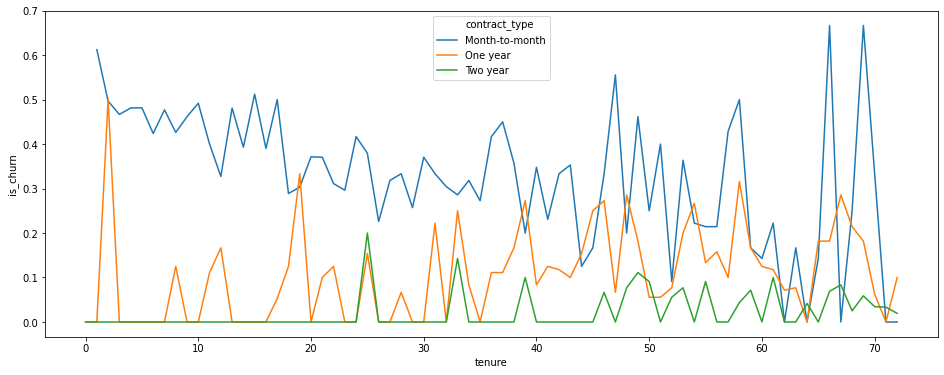

In [24]:
plt.figure(figsize=(16,6))
sns.lineplot('tenure', 'is_churn', hue='contract_type', data=train, ci=None)

If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

$Churn rate = \frac{(nusers at beginning of period - n users at end period)}{users at beggining period}$

In [55]:
contract = train.contract_type == "Month-to-month"
no_churn = train.churn == "Yes"
tenure = train.tenure <= 12


churn_rate_m = (train[contract & tenure].shape[0] - train[contract & yes_churn & tenure].shape[0]) / train[contract & tenure].shape[0]

In [56]:
contract = train.contract_type == "One year"
no_churn = train.churn == "Yes"
tenure = train.tenure <= 12

churn_rate_1 = (train[contract & tenure].shape[0] - train[contract & yes_churn & tenure].shape[0]) / train[contract & tenure].shape[0]

In [63]:
print(f'''

After the 12th month, the churn rate for customers on a month-to-month plan is {churn_rate_m:.1%}, while for customers on a 1-year plan is {churn_rate_1:.1%}

The clearly tells us that the churn rate is not comparable between both services. The key-takeway here is that we need to convert more month-to-month customers into yearly customers, as they are less likely to churn
''')



After the 12th month, the churn rate for customers on a month-to-month plan is 50.4%, while for customers on a 1-year plan is 8.0%

The clearly tells us that the churn rate is not comparable between both services. The key-takeway here is that we need to convert more month-to-month customers into yearly customers, as they are less likely to churn

